# Model Evaluation & Visualization

This notebook provides comprehensive evaluation and visualization of the fine-tuned customer support quality classifier model.

**Contents:**
- Load the fine-tuned model
- Generate predictions on test data
- Create confusion matrix and classification report
- Visualize performance metrics
- ROC and Precision-Recall curves
- Feature importance analysis
- Error analysis

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification
)
from datasets import Dataset
import torch
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

✅ Libraries imported successfully
PyTorch version: 2.9.1+cpu
Device: CPU


## Load the Fine-tuned Model

In [2]:
# Path to the saved model
model_path = "../models/customer-support-classifier-final"

# Check if model exists
if not Path(model_path).exists():
    print(f"❌ Model not found at: {model_path}")
    print("Please run the model_finetuning.ipynb notebook first to train the model.")
else:
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    
    # Move model to appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    print(f"✅ Model loaded successfully from: {model_path}")
    print(f"Model device: {device}")
    print(f"Model type: {type(model).__name__}")
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

✅ Model loaded successfully from: ../models/customer-support-classifier-final
Model device: cpu
Model type: BertForSequenceClassification
Number of parameters: 125,978,114


## Load Test Data

Load the transcript data for evaluation.

In [3]:
def load_transcripts(folder_path, label):
    """Load all transcript files from a folder."""
    folder = Path(folder_path)
    
    if not folder.exists():
        print(f"⚠️  Folder not found: {folder_path}")
        return []
    
    data = []
    txt_files = sorted(folder.glob("*.txt"))
    
    for txt_file in txt_files:
        try:
            text = txt_file.read_text(encoding='utf-8').strip()
            if text:
                data.append({
                    'text': text,
                    'label': label,
                    'filename': txt_file.name
                })
        except Exception as e:
            print(f"❌ Error reading {txt_file.name}: {e}")
    
    return data

# Load good answers (label=1)
good_data = load_transcripts("../data/good_answer_transcripts", label=1)
print(f"✅ Loaded {len(good_data)} good answers")

# Load bad answers (label=0)
bad_data = load_transcripts("../data/bad_answer_transcripts", label=0)
print(f"❌ Loaded {len(bad_data)} bad answers")

# Combine datasets
all_data = good_data + bad_data
df = pd.DataFrame(all_data)

print(f"\n📊 Total samples: {len(df)}")
print(f"   Good answers: {len(good_data)} ({len(good_data)/len(df)*100:.1f}%)")
print(f"   Bad answers:  {len(bad_data)} ({len(bad_data)/len(df)*100:.1f}%)")
print(f"\n📝 Sample text lengths:")
print(f"   Mean: {df['text'].str.len().mean():.0f} characters")
print(f"   Median: {df['text'].str.len().median():.0f} characters")
print(f"   Max: {df['text'].str.len().max():.0f} characters")

✅ Loaded 33 good answers
❌ Loaded 13 bad answers

📊 Total samples: 46
   Good answers: 33 (71.7%)
   Bad answers:  13 (28.3%)

📝 Sample text lengths:
   Mean: 506 characters
   Median: 366 characters
   Max: 2494 characters


## Generate Predictions

Run the model on all data and collect predictions, probabilities, and true labels.

In [4]:
def predict_batch(texts, batch_size=16):
    """Generate predictions for a batch of texts."""
    all_predictions = []
    all_probabilities = []
    all_logits = []
    
    model.eval()
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        # Tokenize
        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=256
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Get predictions
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1)
            preds = torch.argmax(logits, dim=-1)
        
        all_predictions.extend(preds.cpu().numpy())
        all_probabilities.extend(probs.cpu().numpy())
        all_logits.extend(logits.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_probabilities), np.array(all_logits)

print("Generating predictions...")
predictions, probabilities, logits = predict_batch(df['text'].tolist())

# Add predictions to dataframe
df['prediction'] = predictions
df['prob_bad'] = probabilities[:, 0]
df['prob_good'] = probabilities[:, 1]
df['confidence'] = np.max(probabilities, axis=1)
df['correct'] = df['prediction'] == df['label']

print("\n✅ Predictions complete!")
print(f"Accuracy: {df['correct'].mean():.2%}")
print(f"\nPrediction distribution:")
print(df['prediction'].value_counts().to_dict())

Generating predictions...

✅ Predictions complete!
Accuracy: 73.91%

Prediction distribution:
{1: 45, 0: 1}


## 1. Confusion Matrix Visualization

Visualize the confusion matrix to understand classification performance.

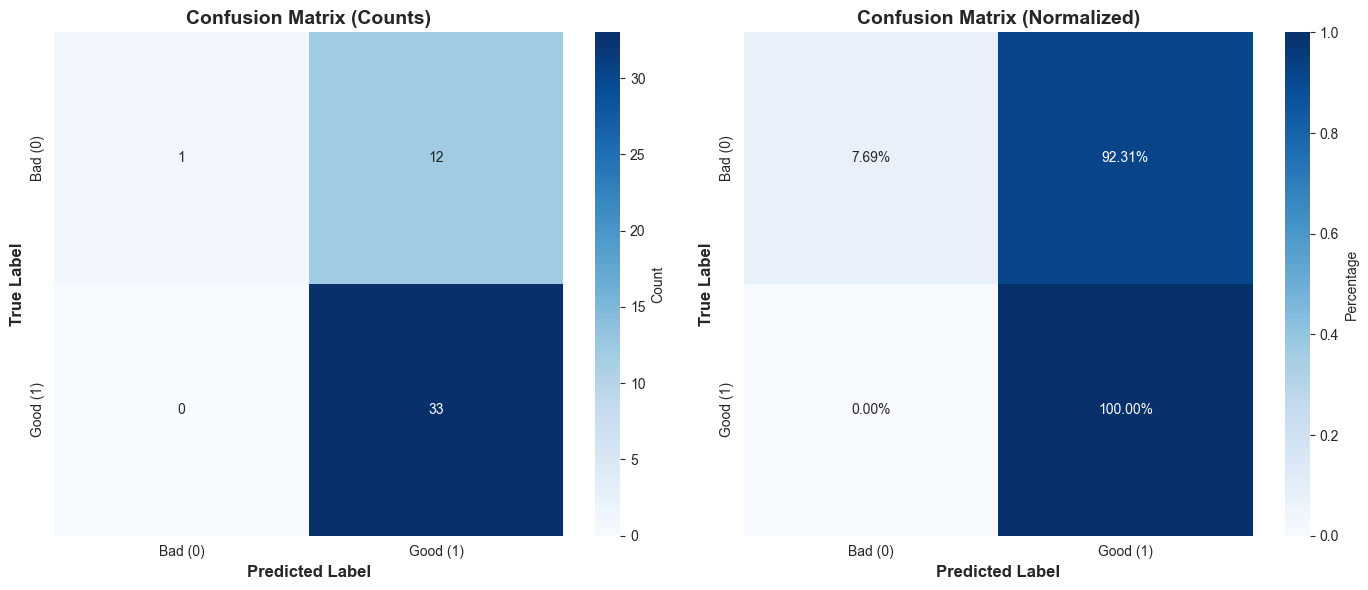


📊 Confusion Matrix Breakdown:
   True Negatives (TN):  1 - Correctly identified bad answers
   False Positives (FP): 12 - Bad answers misclassified as good
   False Negatives (FN): 0 - Good answers misclassified as bad
   True Positives (TP):  33 - Correctly identified good answers

   Sensitivity (TPR): 100.00% - % of good answers correctly identified
   Specificity (TNR): 7.69% - % of bad answers correctly identified


In [5]:
# Calculate confusion matrix
cm = confusion_matrix(df['label'], df['prediction'])

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Confusion Matrix (counts)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bad (0)', 'Good (1)'], 
            yticklabels=['Bad (0)', 'Good (1)'],
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')

# Plot 2: Confusion Matrix (normalized)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['Bad (0)', 'Good (1)'], 
            yticklabels=['Bad (0)', 'Good (1)'],
            ax=axes[1], cbar_kws={'label': 'Percentage'})
axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
print("\n📊 Confusion Matrix Breakdown:")
print(f"   True Negatives (TN):  {tn} - Correctly identified bad answers")
print(f"   False Positives (FP): {fp} - Bad answers misclassified as good")
print(f"   False Negatives (FN): {fn} - Good answers misclassified as bad")
print(f"   True Positives (TP):  {tp} - Correctly identified good answers")
print(f"\n   Sensitivity (TPR): {tp/(tp+fn):.2%} - % of good answers correctly identified")
print(f"   Specificity (TNR): {tn/(tn+fp):.2%} - % of bad answers correctly identified")

## 2. Classification Metrics Dashboard

Display comprehensive classification metrics.

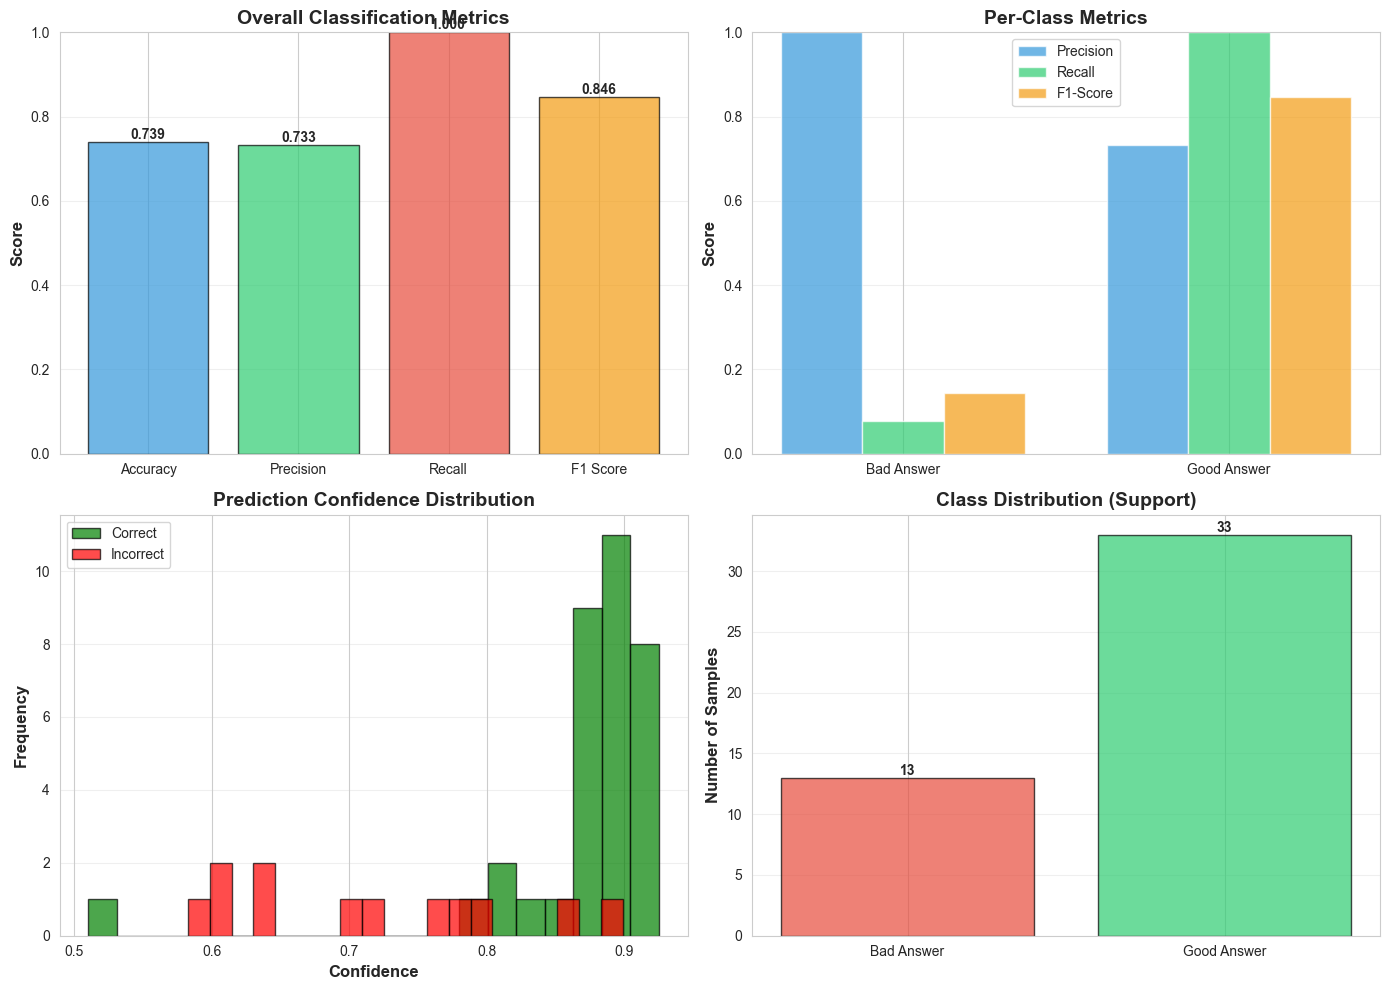


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

  Bad Answer       1.00      0.08      0.14        13
 Good Answer       0.73      1.00      0.85        33

    accuracy                           0.74        46
   macro avg       0.87      0.54      0.49        46
weighted avg       0.81      0.74      0.65        46



In [6]:
# Calculate all metrics
accuracy = accuracy_score(df['label'], df['prediction'])
precision = precision_score(df['label'], df['prediction'])
recall = recall_score(df['label'], df['prediction'])
f1 = f1_score(df['label'], df['prediction'])

# Create classification report
report = classification_report(df['label'], df['prediction'], 
                               target_names=['Bad Answer', 'Good Answer'],
                               output_dict=True)

# Visualize metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Main metrics bar chart
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
bars = axes[0, 0].bar(metrics.keys(), metrics.values(), color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].set_ylim([0, 1.0])
axes[0, 0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Overall Classification Metrics', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontweight='bold')

# Plot 2: Per-class metrics
classes = ['Bad Answer', 'Good Answer']
class_precision = [report['Bad Answer']['precision'], report['Good Answer']['precision']]
class_recall = [report['Bad Answer']['recall'], report['Good Answer']['recall']]
class_f1 = [report['Bad Answer']['f1-score'], report['Good Answer']['f1-score']]

x = np.arange(len(classes))
width = 0.25

bars1 = axes[0, 1].bar(x - width, class_precision, width, label='Precision', color='#3498db', alpha=0.7)
bars2 = axes[0, 1].bar(x, class_recall, width, label='Recall', color='#2ecc71', alpha=0.7)
bars3 = axes[0, 1].bar(x + width, class_f1, width, label='F1-Score', color='#f39c12', alpha=0.7)

axes[0, 1].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Per-Class Metrics', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(classes)
axes[0, 1].legend()
axes[0, 1].set_ylim([0, 1.0])
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Confidence distribution by correctness
correct_conf = df[df['correct']]['confidence']
incorrect_conf = df[~df['correct']]['confidence']

axes[1, 0].hist(correct_conf, bins=20, alpha=0.7, label='Correct', color='green', edgecolor='black')
axes[1, 0].hist(incorrect_conf, bins=20, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
axes[1, 0].set_xlabel('Confidence', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Support (sample count) per class
support = [report['Bad Answer']['support'], report['Good Answer']['support']]
bars = axes[1, 1].bar(classes, support, color=['#e74c3c', '#2ecc71'], alpha=0.7, edgecolor='black')
axes[1, 1].set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Class Distribution (Support)', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed report
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
print(classification_report(df['label'], df['prediction'], 
                           target_names=['Bad Answer', 'Good Answer']))

## 3. ROC Curve and AUC Score

Plot the Receiver Operating Characteristic curve and calculate Area Under the Curve.

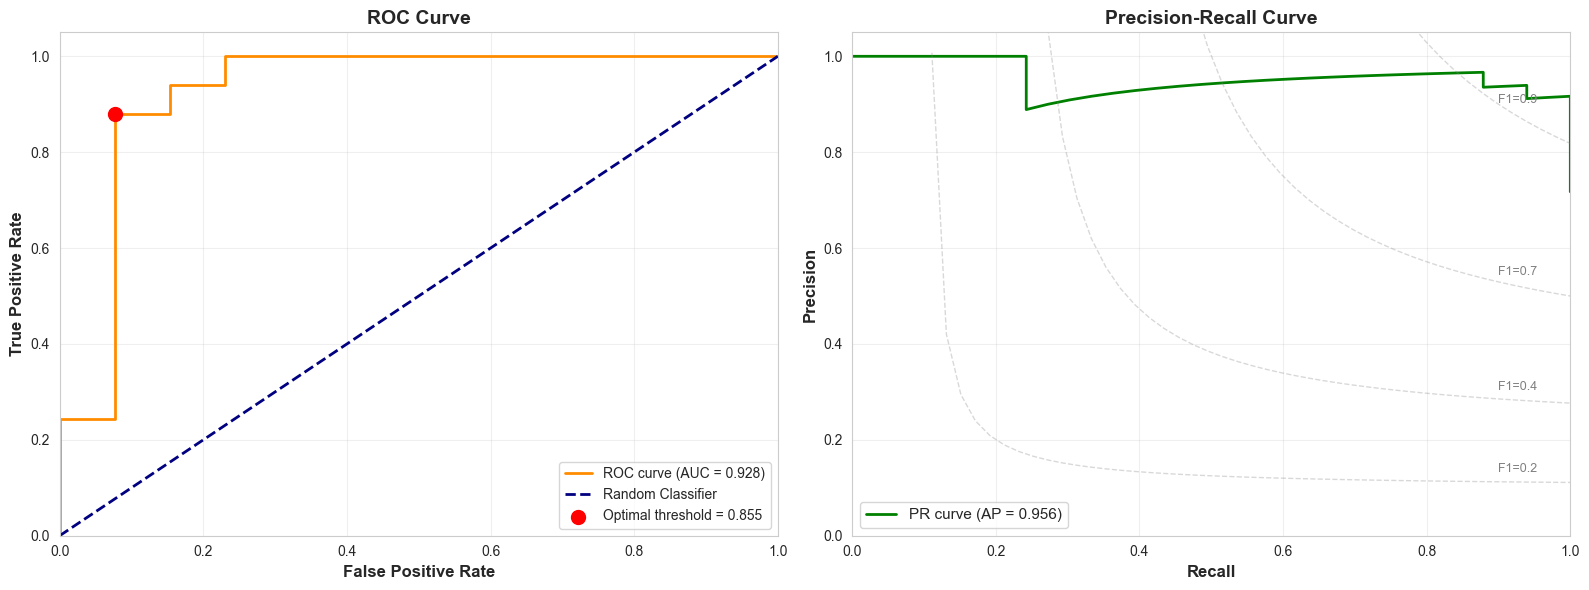


📊 ROC Analysis:
   AUC Score: 0.9277
   Optimal Threshold: 0.8550
   TPR at optimal: 0.8788
   FPR at optimal: 0.0769

📊 Precision-Recall Analysis:
   Average Precision: 0.9558
   Max F1 Score: 0.8462


In [7]:
# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(df['label'], df['prob_good'])
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(df['label'], df['prob_good'])
avg_precision = average_precision_score(df['label'], df['prob_good'])

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: ROC Curve
axes[0].plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[0].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0].legend(loc="lower right", fontsize=11)
axes[0].grid(alpha=0.3)

# Add optimal threshold point
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds_roc[optimal_idx]
axes[0].scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', 
                s=100, label=f'Optimal threshold = {optimal_threshold:.3f}', zorder=5)
axes[0].legend(loc="lower right", fontsize=10)

# Plot 2: Precision-Recall Curve
axes[1].plot(recall_curve, precision_curve, color='green', lw=2,
             label=f'PR curve (AP = {avg_precision:.3f})')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Precision', fontsize=12, fontweight='bold')
axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower left", fontsize=11)
axes[1].grid(alpha=0.3)

# Add F1 iso-curves
f_scores = np.linspace(0.2, 0.9, num=4)
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    axes[1].plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.3, linestyle='--', lw=1)
    axes[1].annotate(f'F1={f_score:.1f}', xy=(0.9, y[45] + 0.02), fontsize=9, color='gray')

plt.tight_layout()
plt.show()

print(f"\n📊 ROC Analysis:")
print(f"   AUC Score: {roc_auc:.4f}")
print(f"   Optimal Threshold: {optimal_threshold:.4f}")
print(f"   TPR at optimal: {tpr[optimal_idx]:.4f}")
print(f"   FPR at optimal: {fpr[optimal_idx]:.4f}")
print(f"\n📊 Precision-Recall Analysis:")
print(f"   Average Precision: {avg_precision:.4f}")
print(f"   Max F1 Score: {f1:.4f}")

## 4. Probability Distribution Analysis

Analyze the distribution of predicted probabilities.

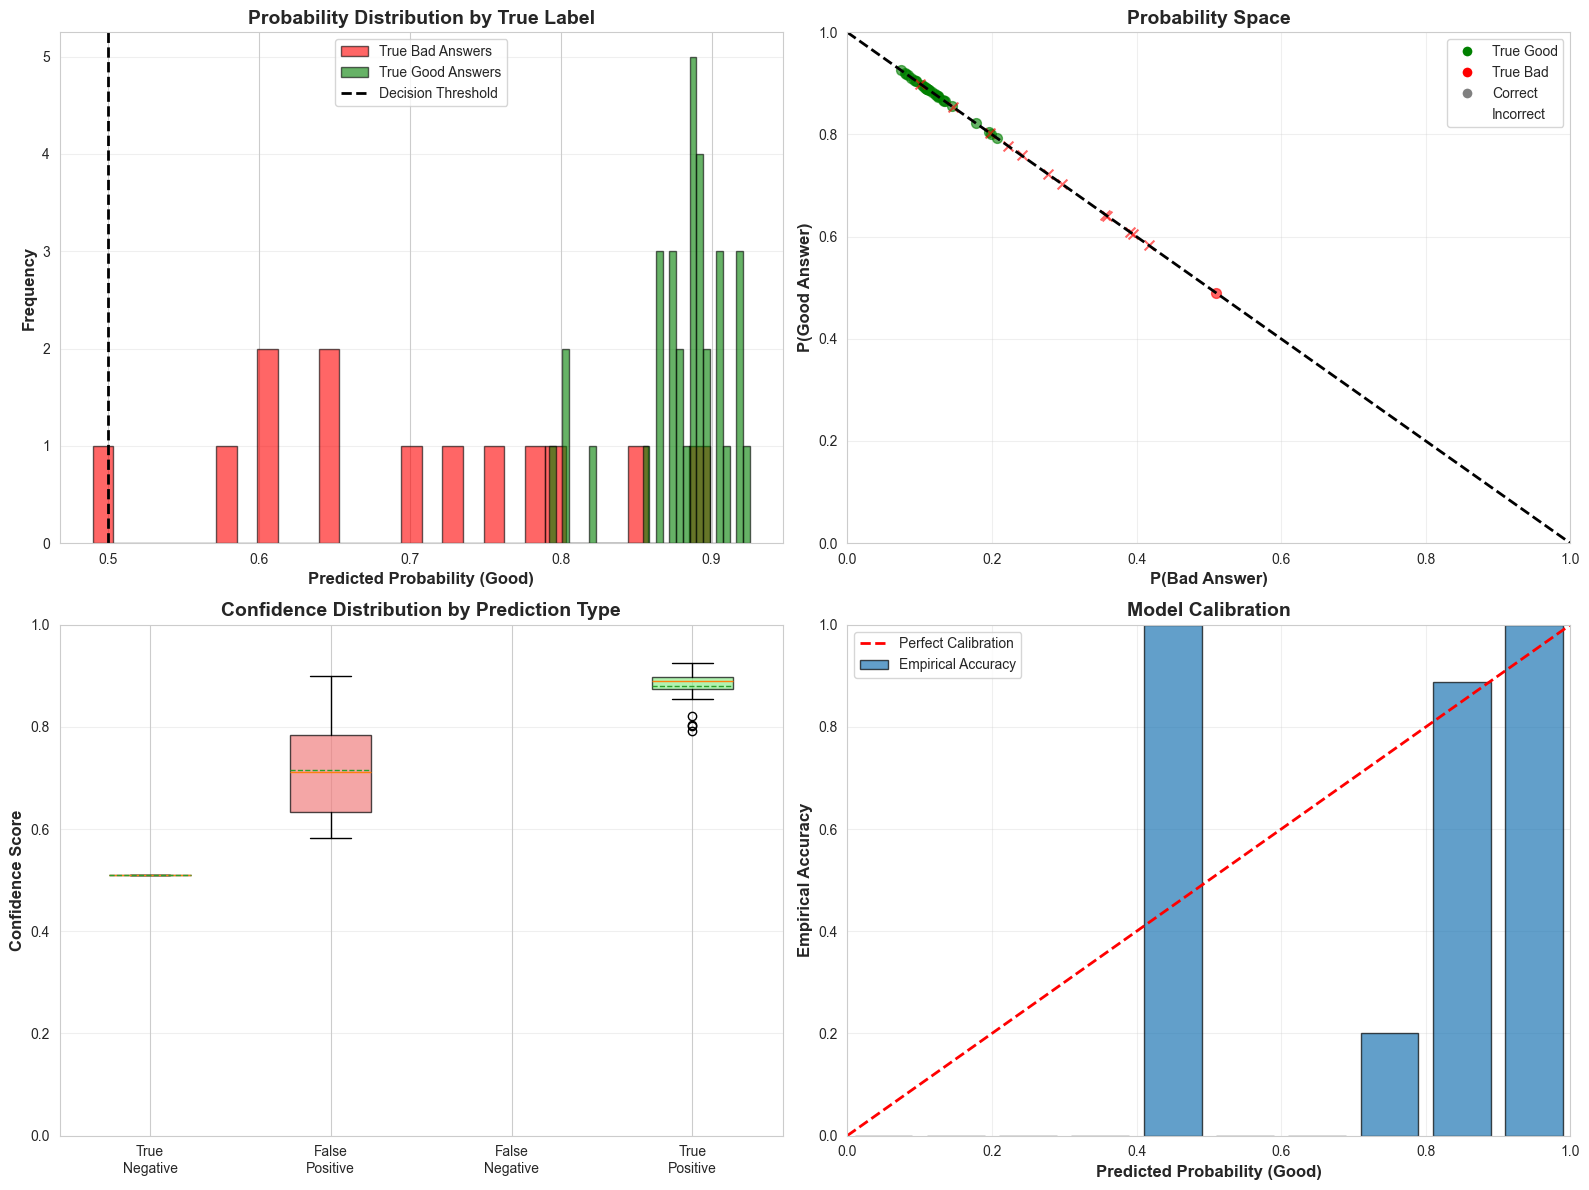


📊 Calibration Statistics:
   Mean confidence (correct): 0.8694
   Mean confidence (incorrect): 0.7164
   Samples with >90% confidence: 8 (17.4%)
   Accuracy for >90% confidence: 100.00%


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Probability distributions by true label
axes[0, 0].hist(df[df['label']==0]['prob_good'], bins=30, alpha=0.6, 
                label='True Bad Answers', color='red', edgecolor='black')
axes[0, 0].hist(df[df['label']==1]['prob_good'], bins=30, alpha=0.6, 
                label='True Good Answers', color='green', edgecolor='black')
axes[0, 0].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
axes[0, 0].set_xlabel('Predicted Probability (Good)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Probability Distribution by True Label', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Scatter plot of probabilities
colors = ['red' if label == 0 else 'green' for label in df['label']]
markers = ['x' if not correct else 'o' for correct in df['correct']]

for i, (prob_bad, prob_good, color, marker, correct) in enumerate(zip(
    df['prob_bad'], df['prob_good'], colors, markers, df['correct'])):
    axes[0, 1].scatter(prob_bad, prob_good, c=color, marker=marker, 
                      alpha=0.6, s=50,
                      label='Correct' if i == 0 and correct else ('Incorrect' if i == 0 else None))

axes[0, 1].plot([0, 1], [1, 0], 'k--', linewidth=2, label='Decision Boundary')
axes[0, 1].set_xlabel('P(Bad Answer)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('P(Good Answer)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Probability Space', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_xlim([0, 1])
axes[0, 1].set_ylim([0, 1])

# Create custom legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=8, label='True Good'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=8, label='True Bad'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=8, label='Correct'),
    Line2D([0], [0], marker='x', color='w', markerfacecolor='gray', markersize=8, label='Incorrect')
]
axes[0, 1].legend(handles=legend_elements, loc='upper right')

# Plot 3: Confidence by prediction outcome
data_to_plot = [
    df[(df['label']==0) & (df['prediction']==0)]['confidence'],  # True Negative
    df[(df['label']==0) & (df['prediction']==1)]['confidence'],  # False Positive
    df[(df['label']==1) & (df['prediction']==0)]['confidence'],  # False Negative
    df[(df['label']==1) & (df['prediction']==1)]['confidence'],  # True Positive
]
labels = ['True\nNegative', 'False\nPositive', 'False\nNegative', 'True\nPositive']
colors_box = ['lightblue', 'lightcoral', 'lightyellow', 'lightgreen']

bp = axes[1, 0].boxplot(data_to_plot, labels=labels, patch_artist=True,
                        showmeans=True, meanline=True)

for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[1, 0].set_ylabel('Confidence Score', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Confidence Distribution by Prediction Type', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].set_ylim([0, 1])

# Plot 4: Calibration analysis (binned)
n_bins = 10
bin_edges = np.linspace(0, 1, n_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_accuracies = []
bin_counts = []

for i in range(n_bins):
    mask = (df['prob_good'] >= bin_edges[i]) & (df['prob_good'] < bin_edges[i+1])
    if mask.sum() > 0:
        bin_accuracies.append(df[mask]['correct'].mean())
        bin_counts.append(mask.sum())
    else:
        bin_accuracies.append(0)
        bin_counts.append(0)

axes[1, 1].bar(bin_centers, bin_accuracies, width=0.08, alpha=0.7, 
               edgecolor='black', label='Empirical Accuracy')
axes[1, 1].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Calibration')
axes[1, 1].set_xlabel('Predicted Probability (Good)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Empirical Accuracy', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Model Calibration', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)
axes[1, 1].set_xlim([0, 1])
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Print calibration statistics
print("\n📊 Calibration Statistics:")
print(f"   Mean confidence (correct): {df[df['correct']]['confidence'].mean():.4f}")
print(f"   Mean confidence (incorrect): {df[~df['correct']]['confidence'].mean():.4f}")
print(f"   Samples with >90% confidence: {(df['confidence'] > 0.9).sum()} ({(df['confidence'] > 0.9).mean():.1%})")
print(f"   Accuracy for >90% confidence: {df[df['confidence'] > 0.9]['correct'].mean():.2%}")

## 5. Error Analysis

Analyze misclassified examples to understand model weaknesses.

📊 Error Analysis Summary:
   Total errors: 12
   False Positives (Bad → Good): 12
   False Negatives (Good → Bad): 0


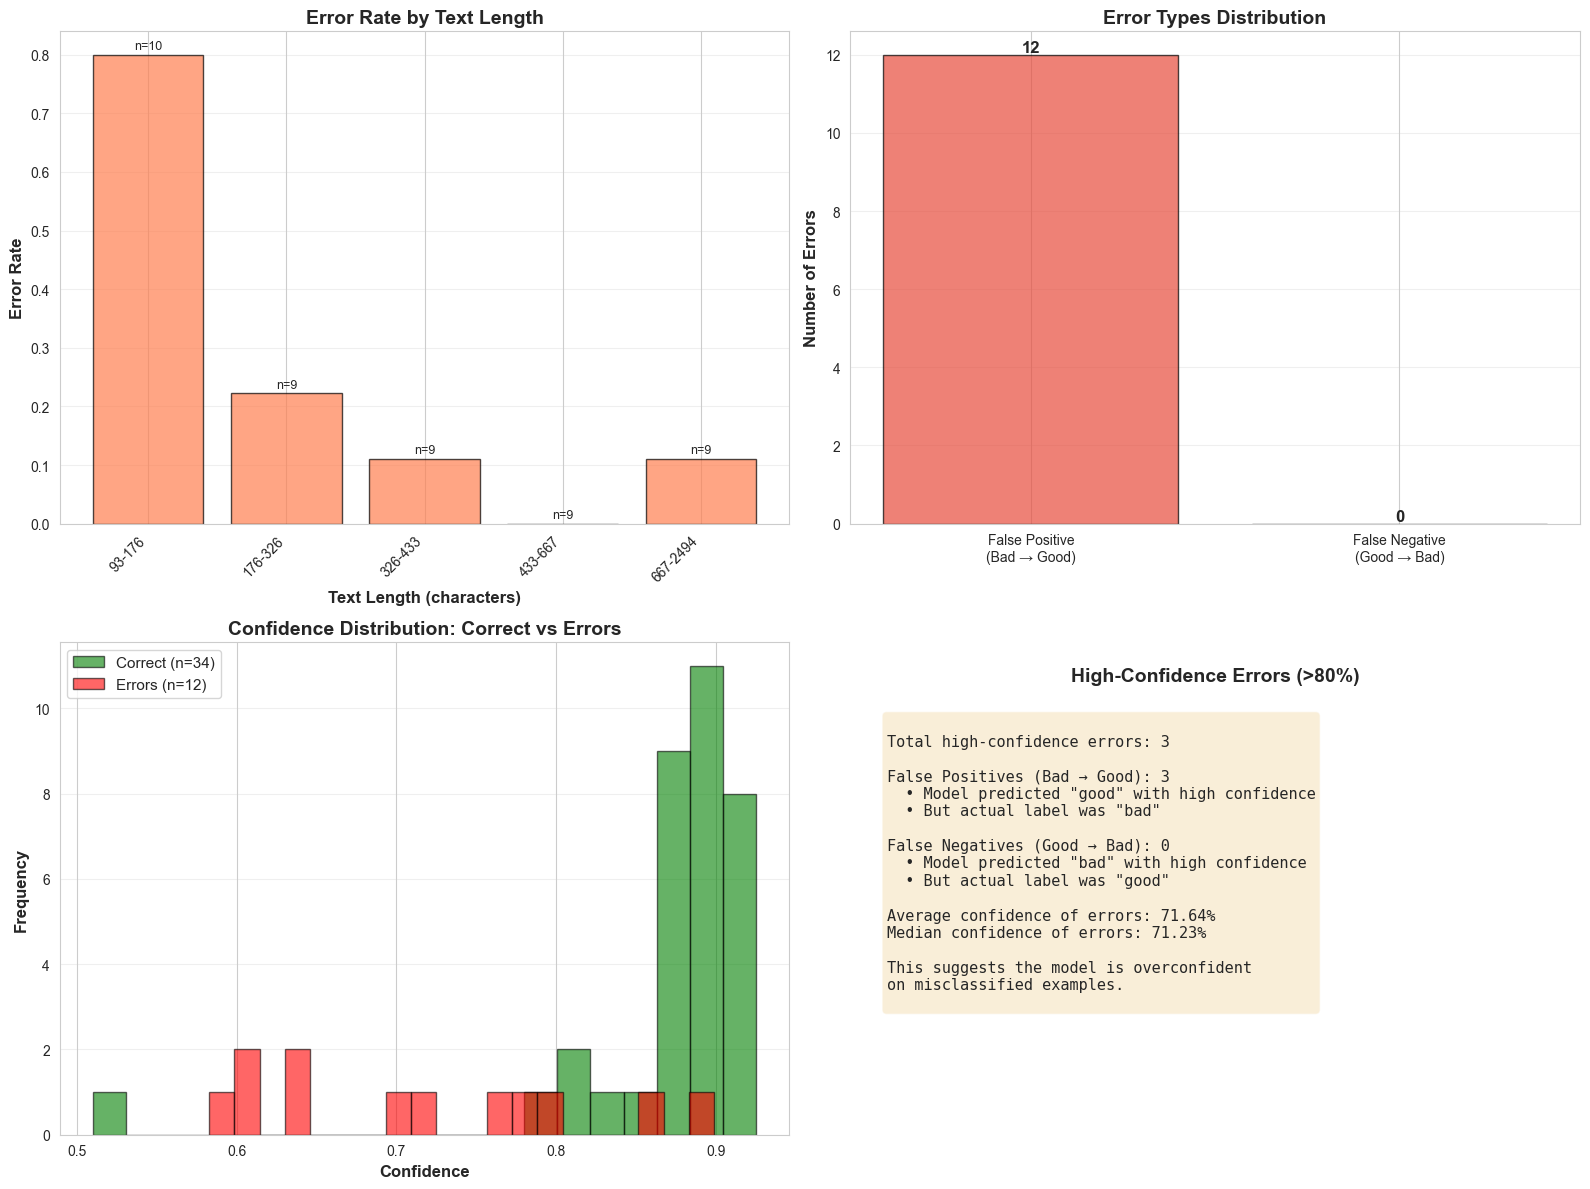


HIGH-CONFIDENCE ERRORS (Top 3)

[Error #1] File: bad_006.txt
True Label: Bad | Predicted: Good | Confidence: 89.89%
Text preview: אם אלחת הציון התמה של אנדסה מחנית, שהוא שיש מושלושים ושיש, ניתן להתקבר לפי ציון של 35 ומה לבחלקה קמותי של הפכינה אבצע החומטרית, זה גם ציון התמה אנדסה שהיא נונא מוכב יותר מחמש נקודות הסף, וגם ציון ומוצ...
------------------------------------------------------------

[Error #2] File: bad_007.txt
True Label: Bad | Predicted: Good | Confidence: 85.32%
Text preview: הם מבחינת קבלה סופית אנחנו אלא נוצפי, מטאה עם הדווחים החלטות סופיות, זה משהו שהוא מעבר על ידי החוג אז אלא נוצפי, צריך להמטין ולתתקן במדעי שי, כשמקבלים החלטה סופית, אז זה מעבר עלינו ובנכנו ודווחים אותה...
------------------------------------------------------------

[Error #3] File: bad_013.txt
True Label: Bad | Predicted: Good | Confidence: 80.21%
Text preview: לא, אתה לא יכול להתקבל לנצת חשמל לפי הנתונים שהמרта, יש חציום פסחומטר 600 ועציון שהם דושים, זה 600-50, אין לך החמש אחדות בפיזיקה מהל 63 וצריך

In [9]:
# Get misclassified examples
errors_df = df[~df['correct']].copy()
errors_df = errors_df.sort_values('confidence', ascending=False)

print(f"📊 Error Analysis Summary:")
print(f"   Total errors: {len(errors_df)}")
print(f"   False Positives (Bad → Good): {((errors_df['label']==0) & (errors_df['prediction']==1)).sum()}")
print(f"   False Negatives (Good → Bad): {((errors_df['label']==1) & (errors_df['prediction']==0)).sum()}")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Error rate by text length
df['text_length'] = df['text'].str.len()
length_bins = pd.qcut(df['text_length'], q=5, duplicates='drop')
error_by_length = df.groupby(length_bins)['correct'].agg(['mean', 'count'])
error_by_length['error_rate'] = 1 - error_by_length['mean']

x_labels = [f"{int(interval.left)}-{int(interval.right)}" for interval in error_by_length.index]
axes[0, 0].bar(range(len(error_by_length)), error_by_length['error_rate'], 
               color='coral', alpha=0.7, edgecolor='black')
axes[0, 0].set_xticks(range(len(error_by_length)))
axes[0, 0].set_xticklabels(x_labels, rotation=45, ha='right')
axes[0, 0].set_xlabel('Text Length (characters)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Error Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Error Rate by Text Length', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Add count labels
for i, (idx, row) in enumerate(error_by_length.iterrows()):
    axes[0, 0].text(i, row['error_rate'] + 0.01, f"n={int(row['count'])}", 
                   ha='center', fontsize=9)

# Plot 2: Error types
error_types = pd.DataFrame({
    'Error Type': ['False Positive\n(Bad → Good)', 'False Negative\n(Good → Bad)'],
    'Count': [
        ((errors_df['label']==0) & (errors_df['prediction']==1)).sum(),
        ((errors_df['label']==1) & (errors_df['prediction']==0)).sum()
    ]
})

bars = axes[0, 1].bar(error_types['Error Type'], error_types['Count'], 
                     color=['#e74c3c', '#3498db'], alpha=0.7, edgecolor='black')
axes[0, 1].set_ylabel('Number of Errors', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Error Types Distribution', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}',
                   ha='center', va='bottom', fontweight='bold', fontsize=12)

# Plot 3: Confidence of errors vs correct predictions
axes[1, 0].hist(df[df['correct']]['confidence'], bins=20, alpha=0.6, 
               label=f'Correct (n={df["correct"].sum()})', color='green', edgecolor='black')
axes[1, 0].hist(errors_df['confidence'], bins=20, alpha=0.6, 
               label=f'Errors (n={len(errors_df)})', color='red', edgecolor='black')
axes[1, 0].set_xlabel('Confidence', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Confidence Distribution: Correct vs Errors', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: High-confidence errors
high_conf_errors = errors_df[errors_df['confidence'] > 0.8]
axes[1, 1].axis('off')
axes[1, 1].text(0.5, 0.95, 'High-Confidence Errors (>80%)', 
               ha='center', va='top', fontsize=14, fontweight='bold',
               transform=axes[1, 1].transAxes)

error_summary = f"""
Total high-confidence errors: {len(high_conf_errors)}

False Positives (Bad → Good): {((high_conf_errors['label']==0) & (high_conf_errors['prediction']==1)).sum()}
  • Model predicted "good" with high confidence
  • But actual label was "bad"
  
False Negatives (Good → Bad): {((high_conf_errors['label']==1) & (high_conf_errors['prediction']==0)).sum()}
  • Model predicted "bad" with high confidence
  • But actual label was "good"

Average confidence of errors: {errors_df['confidence'].mean():.2%}
Median confidence of errors: {errors_df['confidence'].median():.2%}

This suggests the model is {"well-calibrated" if errors_df['confidence'].mean() < 0.7 else "overconfident"}
on misclassified examples.
"""

axes[1, 1].text(0.05, 0.85, error_summary, 
               ha='left', va='top', fontsize=11, family='monospace',
               transform=axes[1, 1].transAxes,
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Show examples of high-confidence errors
if len(high_conf_errors) > 0:
    print("\n" + "="*60)
    print("HIGH-CONFIDENCE ERRORS (Top 3)")
    print("="*60)
    for idx, (i, row) in enumerate(high_conf_errors.head(3).iterrows(), 1):
        true_label = "Good" if row['label'] == 1 else "Bad"
        pred_label = "Good" if row['prediction'] == 1 else "Bad"
        print(f"\n[Error #{idx}] File: {row['filename']}")
        print(f"True Label: {true_label} | Predicted: {pred_label} | Confidence: {row['confidence']:.2%}")
        print(f"Text preview: {row['text'][:200]}...")
        print("-" * 60)